## Hospital Chargemaster Analysis

For this analysis, we want to try predicting price for a given item (possibly for a given hospital) based on the chargemaster data. For example, I would expect items
with the terms "brain" or "heart" to be more expensive than general medications like Advil (ibuprofen). 

The approach we will take is to try a simple linear regression. I don't want to do the ultimate analysis, but rather to show you that the data is interesting.

 1. We first start with data from one hospital. This is to keep the data frame size reasonable to share on GitHub, and also speedy to run on my tiny local machine.
 2. We will then do stop word removal, and make all terms lowercase.
 3. Then we will create a sparse data frame of words (columns) by the unique identifiers (rows). We can use [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) to create this data frame.
 5. The first model we will train is linear regression (possibly with lasso to get more zero entries).

Given over one hundred hospitals, there are definitely more interesting models to build and things
to try! I leave this up to you, dear data scientist. The repository with data files for this analysis is [https://www.github.com/vsoch/hospital-chargemaster-analysis](https://www.github.com/vsoch/hospital-chargemaster-analysis). For the huge database, see [https://www.github.com/vsoch/hospital-chargemaster](https://www.github.com/vsoch/hospital-chargemaster).

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Lasso

In [52]:
import numpy as np
from scipy import sparse
import pandas as pd
import pickle
import matplotlib.pylab as plt

%matplotlib inline

In [3]:
data = pd.read_csv('chargemaster-subset.tsv', delimiter='\t') 

In [11]:
prices = data['price'].values

In [12]:
corpus = data['description']

In [13]:
## specify max number of items and max number of features to use
num_items = 800000
max_features = 5000

In [14]:
prices_short = prices[:num_items]

In [15]:
corpus_short = corpus[:num_items]

In [16]:
## find vocab and sparse forms
vectorizer = CountVectorizer(max_df=0.8, max_features=max_features)
X_short = vectorizer.fit_transform(corpus_short)

In [17]:
## size of shortened matrix
X_short

<726295x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 2490078 stored elements in Compressed Sparse Row format>

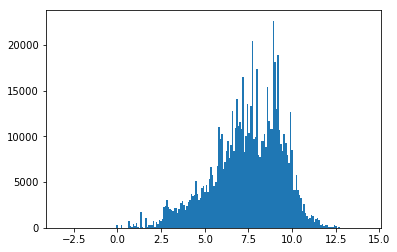

In [139]:
## distribution of prices
## This should be not too far from Gaussian, but it is OK if it is not exactly Gaussian
plt.hist(np.log(prices), bins=200);

In [19]:
## make this smaller if using more features
clf = Lasso(alpha=0.0001)

In [20]:
## Convert to log scale since log prices are roughly Gaussian
log_prices = np.log(prices_short)

In [21]:
%%time
clf.fit(X_short, log_prices)

CPU times: user 4min 57s, sys: 1.46 s, total: 4min 58s
Wall time: 5min 4s


Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [176]:
predictions = clf.predict(X_short)

In [170]:
## Fraction of inputs without meaningful features
## Using more features or lower regularization will reduce this.
y = clf.predict(sparse.csr_matrix((1, 5000)))
num_no_features = len([x for x in predictions if x == y])
print(num_no_features)
print(num_no_features / len(predictions))

14780
0.02034985784013383


In [137]:
## number of effectively nonzero weights (i.e. meaningful features found)
len([x for x in clf.coef_ if x > 1e-8])

1242

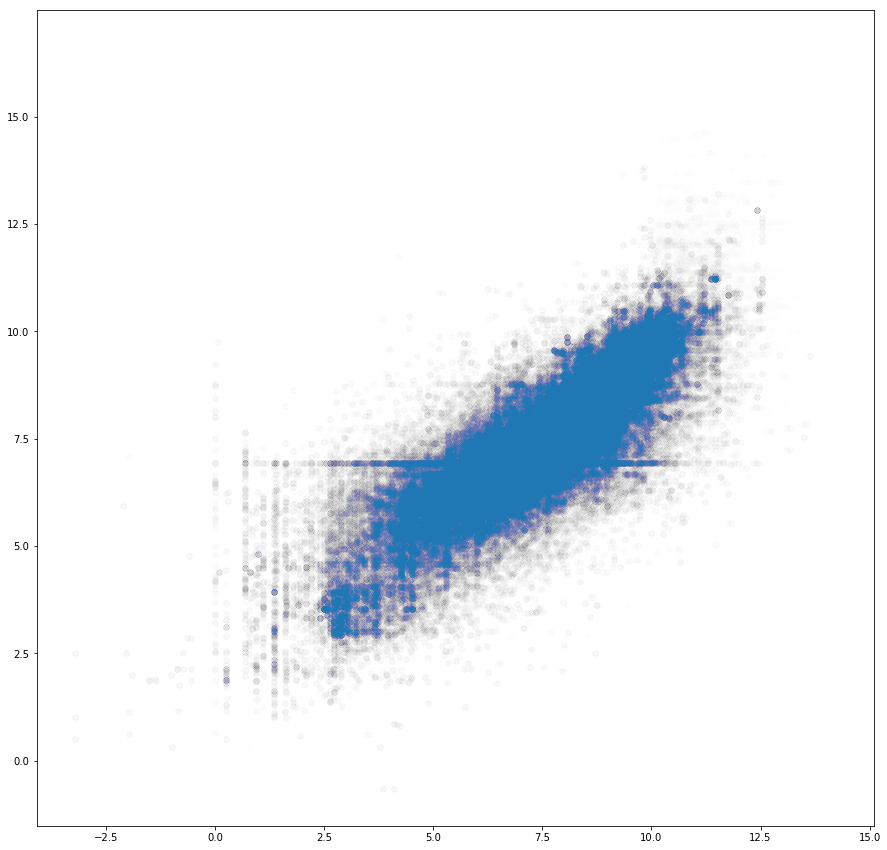

In [24]:
## log prices of items in training set versus predictions
## note: this is the same set used to train.
plt.figure(figsize=(15,15))
plt.scatter(log_prices, predictions, alpha = 0.005)

## horizontal line are inputs who didn't have significant features to train on
## The model cannot make meaninful predictions on those inputs.

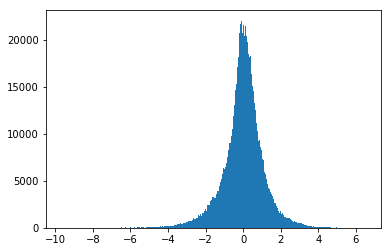

In [138]:
## residual plot should be Gaussian
## This is a good check that the linear model was appropriate
plt.hist(log_prices - predictions, bins = 300);

## A closer look at the weights

In [172]:
## We can look at individual contributions of specific terms
nonzero_values = {val: clf.coef_[num] for val, num in vectorizer.vocabulary_.items() if abs(clf.coef_[num]) > 1e-8}

In [86]:
## e.g.
nonzero_values['mri']

0.89760030616559316

In [210]:
## predicting the cost of a new procedure

sentence = "mri banana cath scan injection"

encoded_sentence = sparse.lil_matrix((1, max_features))
for voc in sentence.split():
    if voc in vectorizer.vocabulary_:
        encoded_sentence[0, vectorizer.vocabulary_[voc]] += 1
prediction = clf.predict(encoded_sentence.toarray())
print(np.e ** prediction[0])

344.930051651


In [233]:
## For fun: most expensive predicted item

most_expensive_predicted = np.argmax(predictions)
print(corpus[most_expensive_predicted])
print("true cost:", prices[most_expensive_predicted])
print("predicted cost:", np.e**predictions[most_expensive_predicted])
print("number of significant words", X_short[most_expensive_predicted].count_nonzero())

## It's likely the predicted cost was so high because there were a lot of high-value words.
## It might be worth trying to normalize the inputs by dividing by a norm, e.g.
## [1, 1, 0, 0] --> [0.5, 0.5, 0, 0] (L1 norm)
## or [1, 1, 0, 0] --> [1/sqrt(2), 1/sqrt(2), 0, 0] (L2 norm)

023 - CRANIO W MAJOR DEV IMPL/ACUTE CNS PDX W MCC OR CHEMO IMPL OR EPILEPSY W NEUROSTM
true cost: 310530.71
predicted cost: 16289314.7274
number of significant words 9


In [234]:
## true most expensive item

true_most_expensive = np.argmax(prices)
print(corpus[true_most_expensive])
print("true cost:", prices[true_most_expensive])
print("predicted cost:", np.e**predictions[true_most_expensive])
print("number of significant words", X_short[true_most_expensive].count_nonzero())


001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC
true cost: 1492111.49
predicted cost: 2206913.83444
number of significant words 7


In [235]:
cheapest_predicted = np.argmin(predictions)
print(corpus[cheapest_predicted])
print("true cost:", prices[cheapest_predicted])
print("predicted cost:", np.e**predictions[cheapest_predicted])
print("number of significant words", X_short[cheapest_predicted].count_nonzero())


DRSG CHG IV PORT 4-3/4IN
true cost: 60.0
predicted cost: 0.524235687498
number of significant words 5


In [236]:
true_cheapest = np.argmin(prices)
print(corpus[true_cheapest])
print("true cost:", prices[true_cheapest])
print("predicted cost:", np.e**predictions[true_cheapest])
print("number of significant words", X_short[true_cheapest].count_nonzero())


POT PHOS 0.05MM/ML SYR  
true cost: 0.04
predicted cost: 1.66907068219
number of significant words 4


## What to do next?

This is obviously just playing around with the data - we don't have any proper setup for the analysis (training and holdout sets) and do nothing to validate the model. Here are some ideas for what one could do next, if your job afforded you time to derive real meaning out of this:

* Set up an experiment setting (training versus holdout sets) where we could experiment with different things. For example, could split hospitals into training and evaluation groups.

* Cleaning up inputs (removing meaningless symbols, maybe stemming, etc.).

* Try normalizing inputs (dividing by L1 or L2 norm) to see if we get better results.

* Run several experiments with different parameters for max_features and alpha.

* Run with (much) more data.

* With features of high importance, try multi-nomial fitting instead of just linear.